In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_Clients_Accounts = pd.read_excel("data/Analytics Showdown Data (Koolboks).xlsx",sheet_name="Clients_Accounts")
df_Payments = pd.read_excel("data/Analytics Showdown Data (Koolboks).xlsx",sheet_name="Payments")
#df_Pricing_Groups = pd.read_excel("data/Analytics Showdown Data (Koolboks).xlsx",sheet_name="Pricing_Groups")

In [3]:
df_Clients_Accounts.columns

Index(['account_qid', 'group_name', 'product', 'product_size', 'group_qid',
       'billing_model', 'currency', 'down_payment',
       'down_payment_days_included', 'minimum_payment', 'full_price',
       'payment_amount_per_period', 'payment_period_in_days',
       'nominal_term_days', 'registration_date', 'total_paid', 'status',
       'cumulative_days_disabled', 'latest_payment_date', 'days_to_cutoff',
       'payment_due_date', 'state', 'lga', 'geolocation', 'gender',
       'client_date_of_birth', 'occupation', 'business_type', 'business_size',
       'monthly_generated_income', 'lead_source', 'product_use'],
      dtype='object')

# TEST

In [5]:
def extract_PAYG(df:pd.DataFrame):
    return df[df['billing_model']=="PAYG"]

df_Clients_PAYG = extract_PAYG(df_Clients_Accounts)
df_Clients_PAYG.shape

(1812, 32)

In [6]:
def regist_time_extraction(df:pd.DataFrame, time_col:str):
    # Convert 'registration_date' to datetime
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Extract year, month, and weekday
    df[time_col+'_year'] = df[time_col].dt.year
    df[time_col+'_month'] = df[time_col].dt.month
    df[time_col+'_weekday'] = df[time_col].dt.day_name() 
    
    # Return the modified DataFrame
    return df

df_Clients_PAYG = regist_time_extraction(df_Clients_Accounts,'registration_date')
df_Clients_PAYG = regist_time_extraction(df_Clients_Accounts,'latest_payment_date')

In [5]:
df_Clients_PAYG.registration_date_month

0        3
1        3
2        3
3        3
4        3
        ..
2898     1
2899     1
2900     1
2901    12
2902    12
Name: registration_date_month, Length: 2903, dtype: int32

In [6]:
df_Clients_PAYG.latest_payment_date_month

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
2898     1.0
2899     1.0
2900     1.0
2901    12.0
2902    12.0
Name: latest_payment_date_month, Length: 2903, dtype: float64

c:\Users\anson\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anson\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


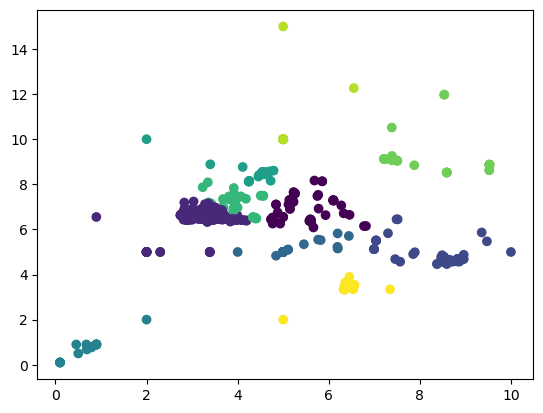

In [30]:
from sklearn.cluster import KMeans

def long_lat(df:pd.DataFrame):
    # Split 'geolocation' into 'latitude' and 'longitude'
    df[['latitude', 'longitude']] = df['geolocation'].str.split(',', expand=True)
    # Convert 'latitude' and 'longitude' to float
    df['latitude'] = pd.to_numeric(df['latitude'])
    df['longitude'] = pd.to_numeric(df['longitude'])

    X= df[df[['latitude', 'longitude']]\
                    .notna().all(axis=1)][['latitude', 'longitude']]

    X = X[X["latitude"]<=20]
    X = X[X["longitude"]<=25]

    # Kmean for cluster the geo
    km = KMeans(n_clusters=10, random_state=0)
    km.fit(X)

    plt.scatter(X['longitude'], X['latitude'], c=km.labels_)
    
    X["geo_cluster"] = km.labels_

    df = df.merge(X, left_index=True,right_index=True, how='left')
    df = df.drop(["latitude_y","longitude_y"],axis=1)
    df = df.rename(columns={"latitude_x":"latitude","longitude_x":"longitude"})
    df.loc[df['geolocation'].notna() & df['geo_cluster'].isna(),"geo_cluster"] =  10
    return df


df_Clients_PAYG = long_lat(df_Clients_Accounts)

In [28]:
def mean_income(df:pd.DataFrame):
    # Function to calculate the mean income from the range string
    def calculate_mean(range_str):
        if range_str == "50,000 and Below":
            return 25000
        elif range_str == "1,000,001 and Above":
            return 2000000
        else:
            if pd.notna(range_str):
                lhs, rhs = range_str.replace(',', '').split(' – ')
                lhs = int(lhs)
                rhs = int(rhs)
                return (lhs + rhs) / 2
    
    df['mean_income'] = df['monthly_generated_income'].apply(calculate_mean)
    return df

df_Clients_PAYG = mean_income(df_Clients_Accounts)

In [ ]:
df_Clients_Accounts.mean_income

0       450000.5
1       125000.5
2       350000.5
3        25000.0
4       125000.5
          ...   
2898         NaN
2899    125000.5
2900    450000.5
2901    450000.5
2902         NaN
Name: mean_income, Length: 2903, dtype: float64

In [ ]:
def age_transform(df:pd.DataFrame):
    # Convert dates of birth to datetime objects
    df['client_date_of_birth'] = pd.to_datetime(df['client_date_of_birth'])

    # Calculate ages
    current_date = datetime.now()
    df['age'] = current_date.year - df['client_date_of_birth'].dt.year
    return df

df_Clients_PAYG = age_transform(df_Clients_Accounts)

In [ ]:
df_Clients_PAYG.age

0       47.0
1       45.0
2       42.0
3       48.0
4       44.0
        ... 
2898    31.0
2899     NaN
2900     NaN
2901     NaN
2902     NaN
Name: age, Length: 2903, dtype: float64

In [ ]:
df_Payments.groupby('account_qid',as_index=False).size()

,account_qid,size
0,AC10006241,1
1,AC10011485,1
2,AC10013964,1
3,AC10039417,3
4,AC10039418,1
...,...,...
3684,AC9989458,1
3685,AC9989568,1
3686,AC9990753,3
3687,AC9991167,1


In [ ]:
df_Payments['year_month'] = pd.to_datetime(df_Payments['effective_date']).dt.year.astype(str) + "-" \
    + pd.to_datetime(df_Payments['effective_date']).dt.month.astype(str)

df_Payments_freq_monthly = df_Payments.groupby(['account_qid', 'year_month']).size().reset_index(name='freq')

# Group by 'account_qid' and aggregate 'freq' into a list
df_freq_list = df_Payments_freq_monthly.groupby('account_qid')['freq'].apply(list).reset_index()
df_freq_list.freq
df_freq_list['freq'].apply(max)
df_freq_list['freq'].apply(np.mean)

0          [1]
1          [1]
2          [1]
3       [1, 2]
4          [1]
         ...  
3684       [1]
3685       [1]
3686       [3]
3687       [1]
3688       [1]
Name: freq, Length: 3689, dtype: object

0       1
1       1
2       1
3       2
4       1
       ..
3684    1
3685    1
3686    3
3687    1
3688    1
Name: freq, Length: 3689, dtype: int64

0       1.0
1       1.0
2       1.0
3       1.5
4       1.0
       ... 
3684    1.0
3685    1.0
3686    3.0
3687    1.0
3688    1.0
Name: freq, Length: 3689, dtype: float64

In [ ]:
df_freq_list.loc[1654]

account_qid                                            AC6961854
freq           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: 1654, dtype: object

# Script

In [4]:
from code.feature_engineer import FeatureEngineer 

 # Create an instance of FeatureEngineer
FeatureEngineer = FeatureEngineer()

# Apply feature engineering using the main function
transform_data = FeatureEngineer.transform(df_Clients_Accounts,df_Payments)

c:\Users\anson\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anson\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [11]:
df_Clients_Accounts.shape

(2903, 32)

In [12]:
transform_data.shape

(1812, 50)

In [8]:
FeatureEngineer.categorical_feature_extract

['product_size',
 'state',
 'gender',
 'occupation',
 'business_type',
 'business_size',
 'lead_source',
 'product_use',
 'registration_date_year',
 'registration_date_month',
 'registration_date_weekday',
 'latest_payment_date_year',
 'latest_payment_date_month',
 'latest_payment_date_weekday',
 'geo_cluster',
 'default']

In [9]:
FeatureEngineer.numerical_feature_extract

['down_payment',
 'down_payment_days_included',
 'minimum_payment',
 'full_price',
 'payment_amount_per_period',
 'payment_period_in_days',
 'nominal_term_days',
 'total_paid',
 'mean_income',
 'age',
 'num_payment_term',
 'max_payment_list',
 'mean_payment_list',
 'default_ratio']

In [10]:
FeatureEngineer.categorical_feature_extract+FeatureEngineer.numerical_feature_extract

['product_size',
 'state',
 'gender',
 'occupation',
 'business_type',
 'business_size',
 'lead_source',
 'product_use',
 'registration_date_year',
 'registration_date_month',
 'registration_date_weekday',
 'latest_payment_date_year',
 'latest_payment_date_month',
 'latest_payment_date_weekday',
 'geo_cluster',
 'default',
 'down_payment',
 'down_payment_days_included',
 'minimum_payment',
 'full_price',
 'payment_amount_per_period',
 'payment_period_in_days',
 'nominal_term_days',
 'total_paid',
 'mean_income',
 'age',
 'num_payment_term',
 'max_payment_list',
 'mean_payment_list',
 'default_ratio']